# <p style='color: #87CEEB; text-align: center'>Prétraitement des Données Financières d'Apple</p>

## <p style='color: #F88379;'>Partie 1 : Web Scraping</p>

Objectif :


Extraire les données historiques d'Apple depuis Yahoo Finance.

1. Importation des Bibliothèques et Modules Nécessaires


In [57]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import os

2. Extration de données

In [58]:
# Créer le dossier "data" s'il n'existe pas
if not os.path.exists("data"):
    os.makedirs("data")

# URL de la page Yahoo Finance pour l'action AAPL avec une plage de dates spécifiée
url = "https://finance.yahoo.com/quote/AAPL/history/?period1=1577836800&period2=1743126119"

# Définir des headers pour imiter un navigateur web
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36"
}

# Envoyer une requête GET vers l'URL
response = requests.get(url, headers=headers)

# Vérifier que la requête a réussi
if response.status_code == 200:
    # Parser le contenu HTML avec BeautifulSoup
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Trouver la table contenant les données (ici, on se base sur la classe "table")
    table = soup.find("table", {"class": "table"})
    
    if table:
        # Extraire les noms des colonnes depuis le thead
        header_tags = table.find("thead").find_all("th")
        headers_list = [th.get_text(strip=True) for th in header_tags]
        print("Headers:", headers_list)
        
        # Extraire les lignes de données du tbody
        rows = []
        for tr in table.find("tbody").find_all("tr"):
            cells = [td.get_text(strip=True) for td in tr.find_all("td")]
            if cells:  # Vérifier que la ligne n'est pas vide
                rows.append(cells)
        print("Rows:", rows)
        
        # Sauvegarder les données dans un fichier CSV
        with open(os.path.join("data", "apple_data.csv"), "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(headers_list)
            writer.writerows(rows)
        print("Les données ont été enregistrées dans apple_data.csv")
    else:
        print("Table non trouvée dans le code HTML.")
else:
    print("Erreur lors de la récupération de la page. Code status:", response.status_code)


Headers: ['Date', 'Open', 'High', 'Low', 'CloseClose price adjusted for splits.', 'Adj CloseAdjusted close price adjusted for splits and dividend and/or capital gain distributions.', 'Volume']
Rows: [['Mar 27, 2025', '221.39', '224.99', '220.56', '223.85', '223.85', '37,094,800'], ['Mar 26, 2025', '223.51', '225.02', '220.47', '221.53', '221.53', '34,466,100'], ['Mar 25, 2025', '220.77', '224.10', '220.08', '223.75', '223.75', '34,493,600'], ['Mar 24, 2025', '221.00', '221.48', '218.58', '220.73', '220.73', '44,299,500'], ['Mar 21, 2025', '211.56', '218.84', '211.28', '218.27', '218.27', '94,127,800'], ['Mar 20, 2025', '213.99', '217.49', '212.22', '214.10', '214.10', '48,862,900'], ['Mar 19, 2025', '214.22', '218.76', '213.75', '215.24', '215.24', '54,385,400'], ['Mar 18, 2025', '214.16', '215.15', '211.49', '212.69', '212.69', '42,432,400'], ['Mar 17, 2025', '213.31', '215.22', '209.97', '214.00', '214.00', '48,073,400'], ['Mar 14, 2025', '211.25', '213.95', '209.58', '213.49', '213.

3. Chargement et Visualisation des Données Brutes


In [59]:
df = pd.read_csv('data/apple_data.csv')
df.head()

,Date,Open,High,Low,CloseClose price adjusted for splits.,Adj CloseAdjusted close price adjusted for splits and dividend and/or capital gain distributions.,Volume
0,"Mar 27, 2025",221.39,224.99,220.56,223.85,223.85,"37,094,800"
1,"Mar 26, 2025",223.51,225.02,220.47,221.53,221.53,"34,466,100"
2,"Mar 25, 2025",220.77,224.10,220.08,223.75,223.75,"34,493,600"
3,"Mar 24, 2025",221.00,221.48,218.58,220.73,220.73,"44,299,500"
4,"Mar 21, 2025",211.56,218.84,211.28,218.27,218.27,"94,127,800"


4. Description des Colonnes

- **Date** : Correspond au jour de négociation (jour de bourse) pour lequel les données sont relevées.  
- **Open** : Le cours d’ouverture de l’action. Il s’agit du premier prix auquel l’action a été échangée lors de l’ouverture du marché ce jour-là.  
- **High** : Le prix le plus élevé atteint par l’action au cours de la séance de trading.  
- **Low** : Le prix le plus bas atteint par l’action au cours de la séance de trading.  
- **Close** : Le cours de clôture de l’action. C’est le dernier prix négocié avant la fermeture du marché.  
- **Adj Close** (Adjusted Close) : Le cours de clôture ajusté pour prendre en compte les dividendes, les splits (fractionnements d’actions) ou d’autres événements. Il permet de suivre plus précisément la performance réelle de l’action dans le temps.  
- **Volume** : Le nombre total d’actions échangées pendant la journée. Cet indicateur donne une idée de la liquidité et de l’intérêt des investisseurs pour l’action sur la période considérée.


## <p style='color: #F88379;'>Partie 2 : Prétraitement et Nettoyage des Données</p>

Objectif :


Charger les données extraites et effectuer les opérations de nettoyage (conversion des types, gestion des valeurs manquantes, suppression de caractères inutiles, etc.).

1. Chargement des Données
Charger le fichier CSV obtenu lors du scraping dans un DataFrame.

In [60]:
# Charger les données depuis le CSV obtenu lors du scraping
df = pd.read_csv("data/apple_data.csv")

# Afficher les 5 premières lignes pour vérifier
print(df.head())


           Date    Open    High     Low  \
0  Mar 27, 2025  221.39  224.99  220.56   
1  Mar 26, 2025  223.51  225.02  220.47   
2  Mar 25, 2025  220.77  224.10  220.08   
3  Mar 24, 2025  221.00  221.48  218.58   
4  Mar 21, 2025  211.56  218.84  211.28   

   CloseClose price adjusted for splits.  \
0                                 223.85   
1                                 221.53   
2                                 223.75   
3                                 220.73   
4                                 218.27   

   Adj CloseAdjusted close price adjusted for splits and dividend and/or capital gain distributions.  \
0                                             223.85                                                   
1                                             221.53                                                   
2                                             223.75                                                   
3                                             220.73        

2. Aperçu de la Structure et des Types de Données

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                                                                                             Non-Null Count  Dtype  
---  ------                                                                                             --------------  -----  
 0   Date                                                                                               1338 non-null   object 
 1   Open                                                                                               1338 non-null   object 
 2   High                                                                                               1316 non-null   float64
 3   Low                                                                                                1316 non-null   float64
 4   CloseClose price adjusted for splits.                                                              1316 non-null   float6

3. Renommage des Colonnes

In [62]:
df.rename(columns={
    "CloseClose price adjusted for splits.": "Close",
    "Adj CloseAdjusted close price adjusted for splits and dividend and/or capital gain distributions.": "Adj Close"
}, inplace=True)

4. Gestion des Valeurs Manquantes


Vérifier la présence de valeurs manquantes et les traiter.

- Identification des Valeurs Manquantes

In [63]:
df.isnull().sum()

Date          0
Open          0
High         22
Low          22
Close        22
Adj Close    22
Volume       22
dtype: int64

- Vérification du Format des Valeurs nulles

In [64]:
# Filtrer et afficher les lignes contenant au moins une valeur nulle
rows_with_null = df[df.isnull().any(axis=1)]
print(rows_with_null)

              Date             Open  High  Low  Close  Adj Close Volume
32    Feb 10, 2025     0.25Dividend   NaN  NaN    NaN        NaN    NaN
94     Nov 8, 2024     0.25Dividend   NaN  NaN    NaN        NaN    NaN
158   Aug 12, 2024     0.25Dividend   NaN  NaN    NaN        NaN    NaN
222   May 10, 2024     0.25Dividend   NaN  NaN    NaN        NaN    NaN
286    Feb 9, 2024     0.24Dividend   NaN  NaN    NaN        NaN    NaN
348   Nov 10, 2023     0.24Dividend   NaN  NaN    NaN        NaN    NaN
413   Aug 11, 2023     0.24Dividend   NaN  NaN    NaN        NaN    NaN
476   May 12, 2023     0.24Dividend   NaN  NaN    NaN        NaN    NaN
540   Feb 10, 2023     0.23Dividend   NaN  NaN    NaN        NaN    NaN
607    Nov 4, 2022     0.23Dividend   NaN  NaN    NaN        NaN    NaN
672    Aug 5, 2022     0.23Dividend   NaN  NaN    NaN        NaN    NaN
735    May 6, 2022     0.23Dividend   NaN  NaN    NaN        NaN    NaN
799    Feb 4, 2022     0.22Dividend   NaN  NaN    NaN        NaN

- Suppression des Lignes avec Valeurs Manquantes

In [65]:
df = df.dropna()

- Vérification Post-Nettoyage des Valeurs Manquantes

In [66]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

5. Conversion de la Colonne Date


Convertir la colonne Date au format datetime pour faciliter les opérations temporelles.

In [67]:
# Conversion de la colonne 'Date' en format datetime
df['Date'] = pd.to_datetime(df['Date'])

6. Nettoyage de la Colonne Volume


Si la colonne Volume contient des virgules, les supprimer et convertir en entier.

In [68]:
# Affichage avant conversion
print("Type de la colonne volume avant conversion :")
print(df['Volume'].dtypes)

# Conversion de la colonne 'Volume' en entier
df['Volume'] = df['Volume'].str.replace(',', '').astype(int)

# Affichage après conversion
print("\nType de la colonne volume après conversion :")
print(df['Volume'].dtypes)


Type de la colonne volume avant conversion :
object

Type de la colonne volume après conversion :
int64


7. Sauvegarde des Données Nettoyées

In [69]:
# Sauvegarder les données nettoyées dans un nouveau fichier CSV
df.to_csv("data/apple_data_clean.csv", index=False, encoding='utf-8')
print("Les données nettoyées ont été enregistrées.")

Les données nettoyées ont été enregistrées.


## <p style='color: #F88379;'>Partie 3 : Analyse Exploratoire des Données</p>

Dans cette section, nous réalisons une analyse descriptive des données :

- Calcul des statistiques descriptives
- Visualisation des tendances (cours, volumes, etc.)
- Détection d'éventuelles anomalies ou outliers
- Normalisation 

1. Importation des Bibliothèques et Modules Nécessaires

In [70]:
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

2. Statistiques Descriptives

In [71]:
df.describe()

,Date,High,Low,Close,Adj Close,Volume
count,1316,1316.000000,1316.000000,1316.000000,1316.000000,1.316000e+03
mean,2022-08-12 21:44:18.966565376,159.148032,155.761208,157.544886,155.694141,8.891685e+07
min,2020-01-02 00:00:00,57.130000,53.150000,56.090000,54.450000,2.323470e+07
25%,2021-04-22 18:00:00,132.100000,128.980000,130.812500,128.130000,5.414120e+07
50%,2022-08-11 12:00:00,157.295000,153.435000,155.340000,153.575000,7.482940e+07
75%,2023-12-01 18:00:00,184.532500,181.455000,182.895000,181.740000,1.054614e+08
max,2025-03-27 00:00:00,260.100000,257.630000,259.020000,258.740000,4.265100e+08
std,NaN,43.899239,43.403676,43.690299,44.328844,5.274972e+07


3. Visualisation des Séries Temporelles

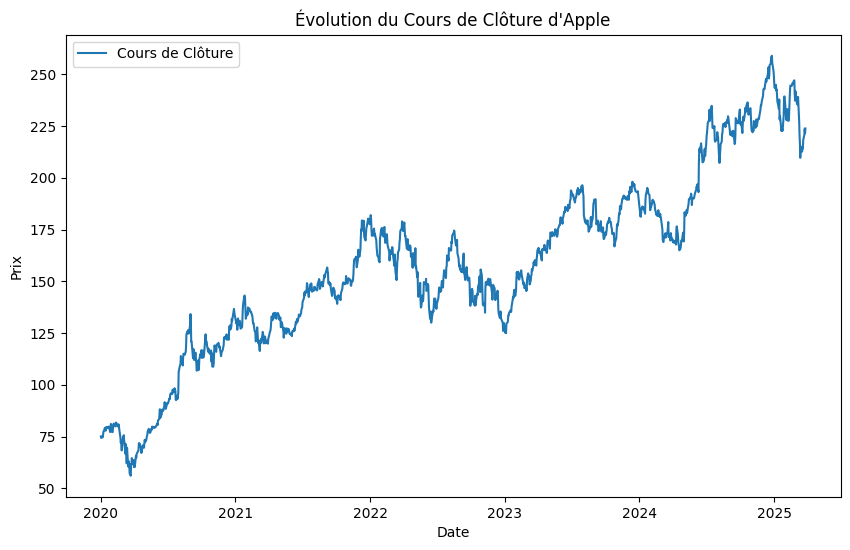

In [72]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label="Cours de Clôture")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.title("Évolution du Cours de Clôture d'Apple")
plt.legend()
plt.show()


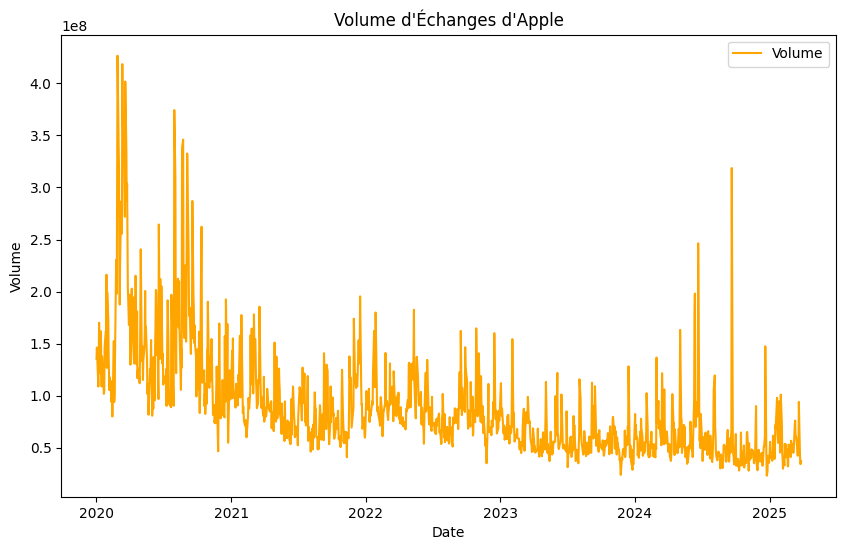

In [73]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Volume'], label="Volume", color='orange')
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume d'Échanges d'Apple")
plt.legend()
plt.show()


4. Distribution des Données

- Histogrammes : Pour visualiser la distribution pour Chaque Colonne Numérique

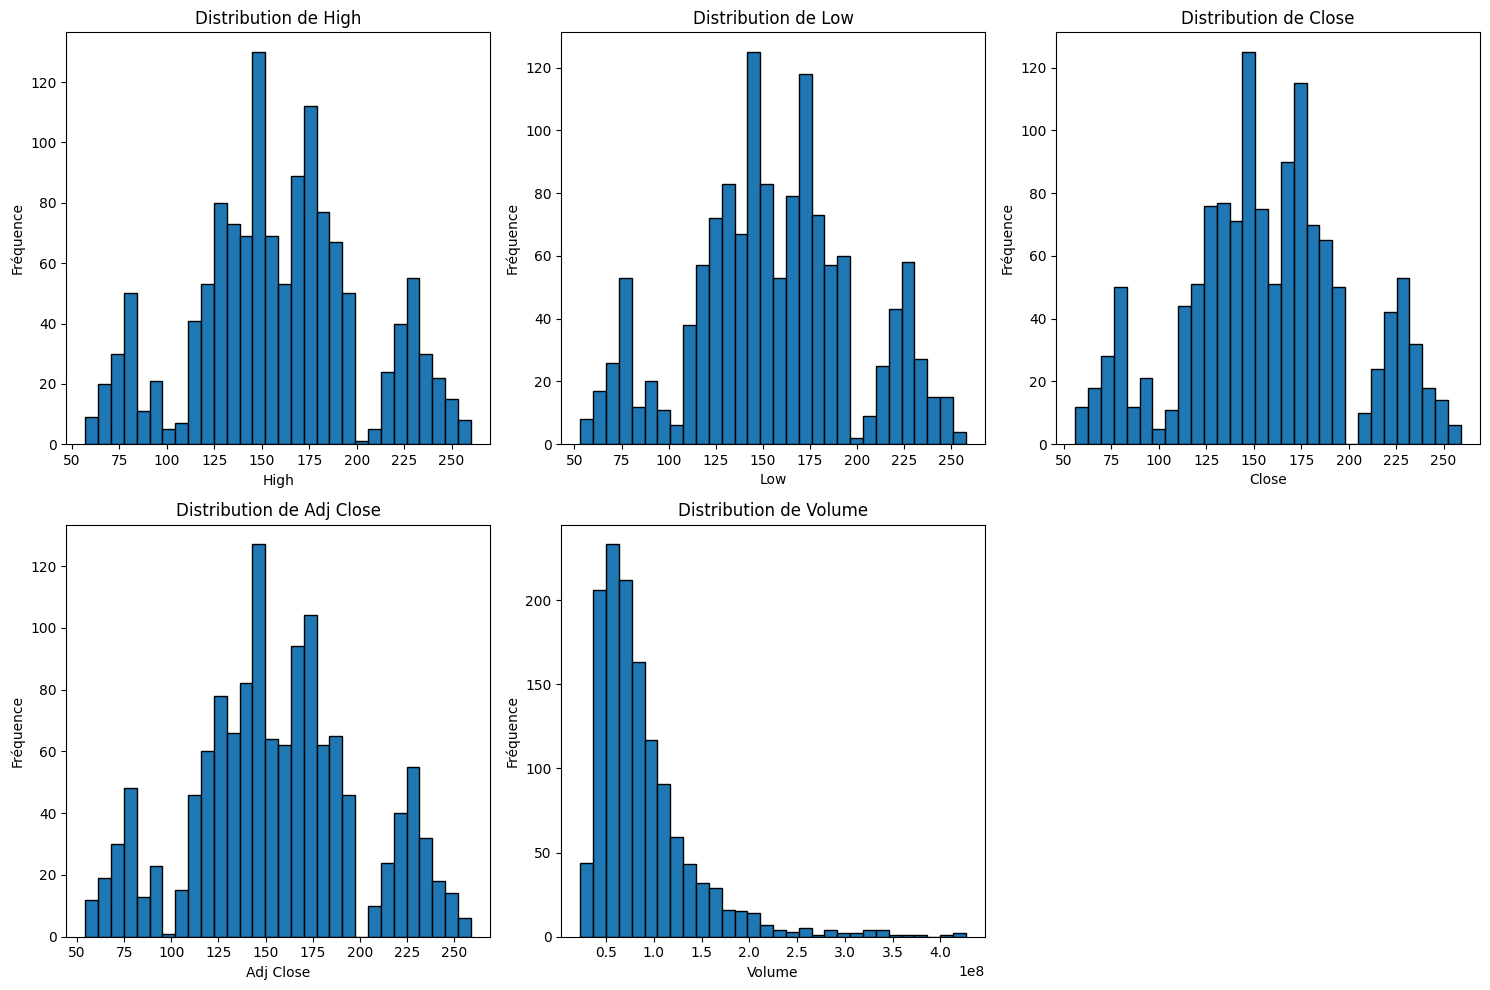

In [74]:
# Sélectionner les colonnes numériques
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
num_plots = len(numeric_columns)
rows = math.ceil(num_plots / 3)  # 3 graphiques par ligne

plt.figure(figsize=(15, 5 * rows))

for i, col in enumerate(numeric_columns):
    plt.subplot(rows, 3, i + 1)
    plt.hist(df[col].dropna(), bins=30, edgecolor='black')
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.title(f"Distribution de {col}")

plt.tight_layout()
plt.show()


- Boxplots : Pour détecter les outliers dans les données (prix, volume, etc.).

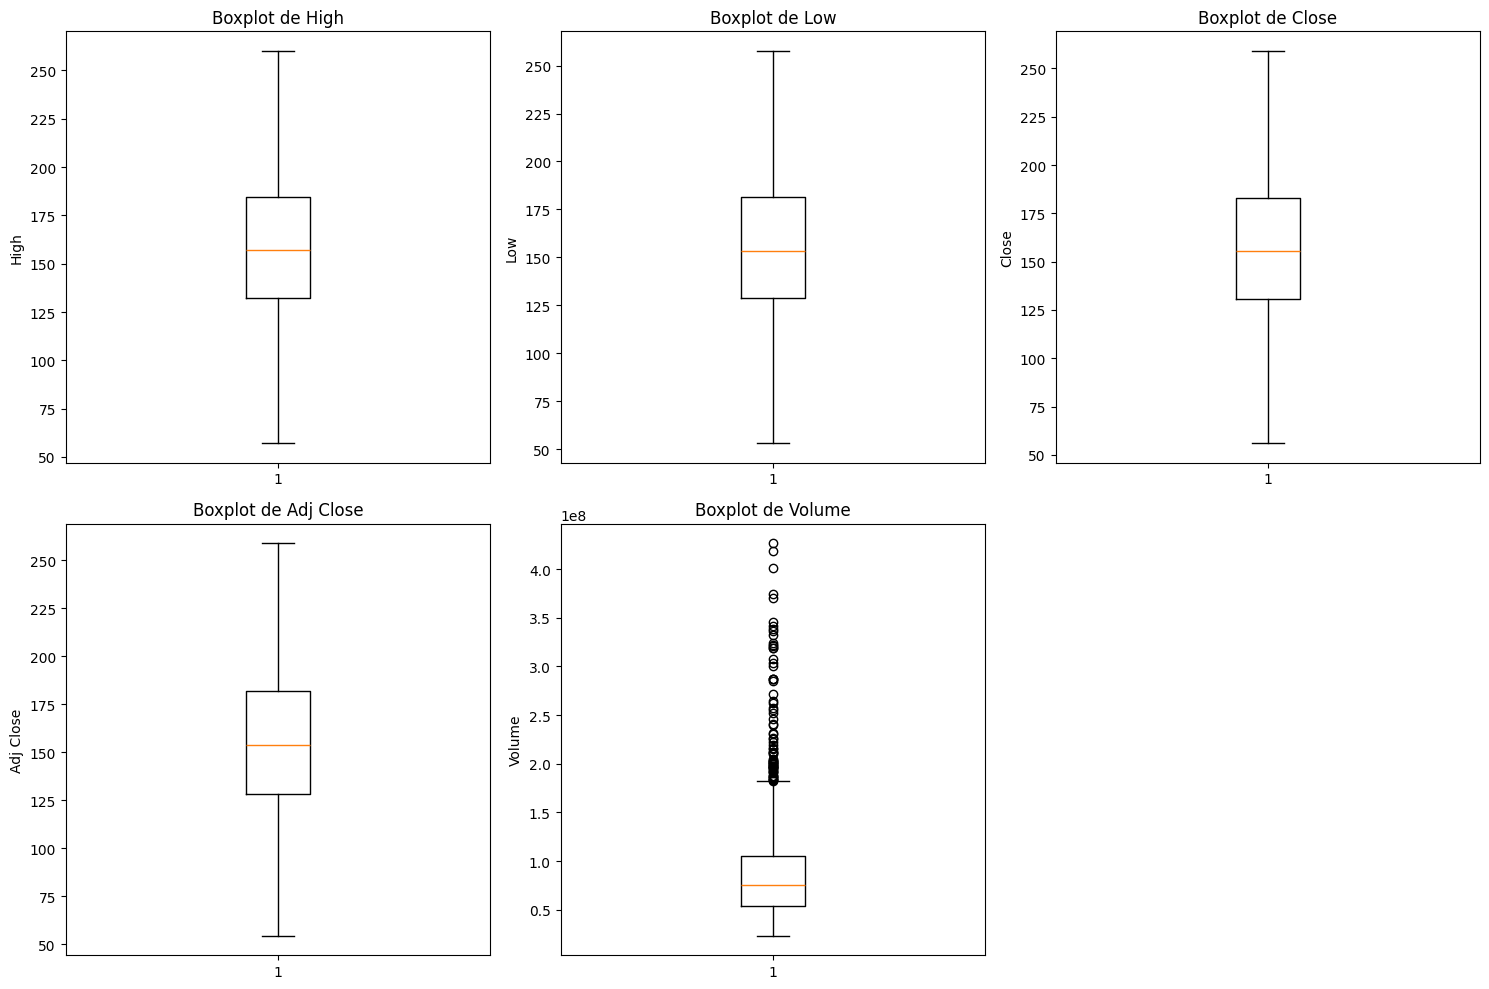

In [75]:
# Sélectionner les colonnes numériques
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
num_plots = len(numeric_columns)
rows = math.ceil(num_plots / 3)  # 3 par ligne

plt.figure(figsize=(15, 5 * rows))

for i, col in enumerate(numeric_columns):
    plt.subplot(rows, 3, i + 1)
    plt.boxplot(df[col].dropna())
    plt.title(f"Boxplot de {col}")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


5. Analyse de la Corrélation

- Matrice de corrélation : Calculer et visualiser la corrélation entre les différentes variables pour identifier les relations potentielles

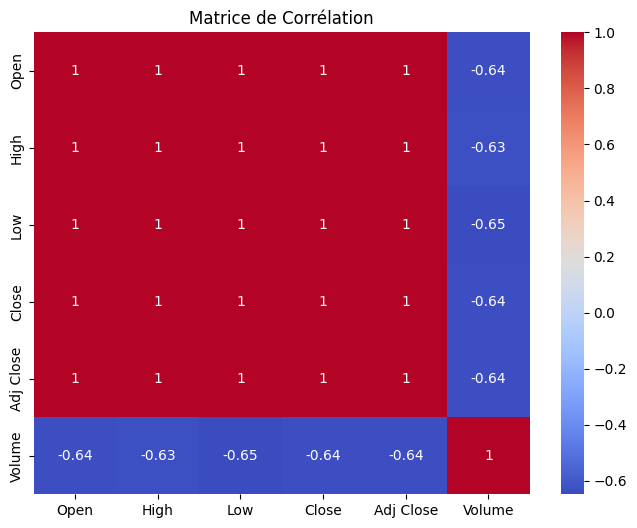

In [76]:
plt.figure(figsize=(8,6))
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matrice de Corrélation")
plt.show()


6. Analyse des Tendances et Saisonnières

Moyennes mobiles : Calculer et tracer des moyennes mobiles pour lisser les fluctuations et mieux visualiser la tendance.

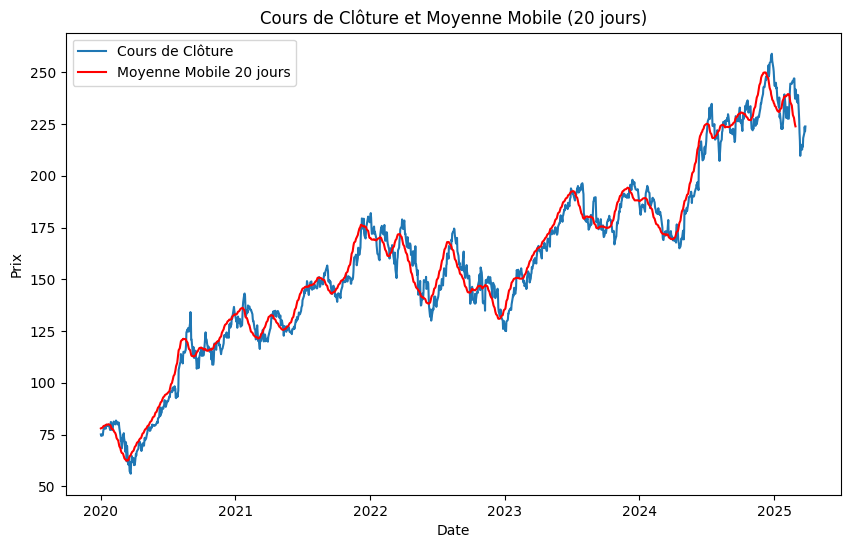

In [77]:
df['MA_20'] = df['Close'].rolling(window=20).mean()
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label="Cours de Clôture")
plt.plot(df['Date'], df['MA_20'], label="Moyenne Mobile 20 jours", color='red')
plt.xlabel("Date")
plt.ylabel("Prix")
plt.title("Cours de Clôture et Moyenne Mobile (20 jours)")
plt.legend()
plt.show()


- Décomposition de la série temporelle : Pour extraire les composantes tendance, saisonnière et résiduelle.

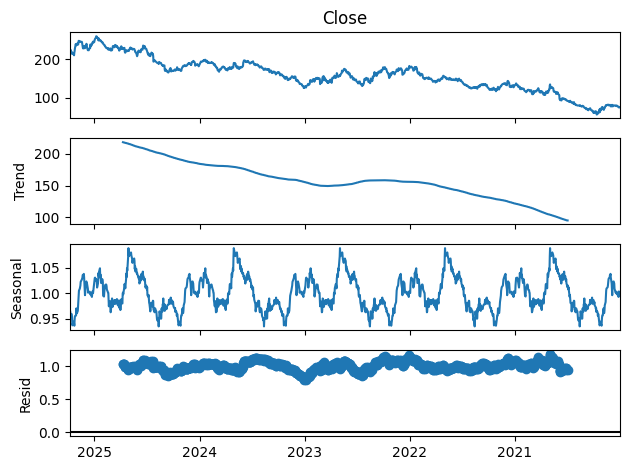

In [78]:
df.set_index('Date', inplace=True)  # Pour une décomposition, l'index doit être de type datetime
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=252)  # Période annuelle approximative pour le marché
decomposition.plot()
plt.show()
df.reset_index(inplace=True)  # Réinitialiser l'index si nécessaire


7. Analyse par Période
- Groupement par année ou par mois : Pour observer l’évolution des prix ou du volume sur des périodes spécifiques.

Year
2020     95.346957
2021    140.989365
2022    154.835060
2023    172.549000
2024    207.205913
2025    232.072931
Name: Close, dtype: float64


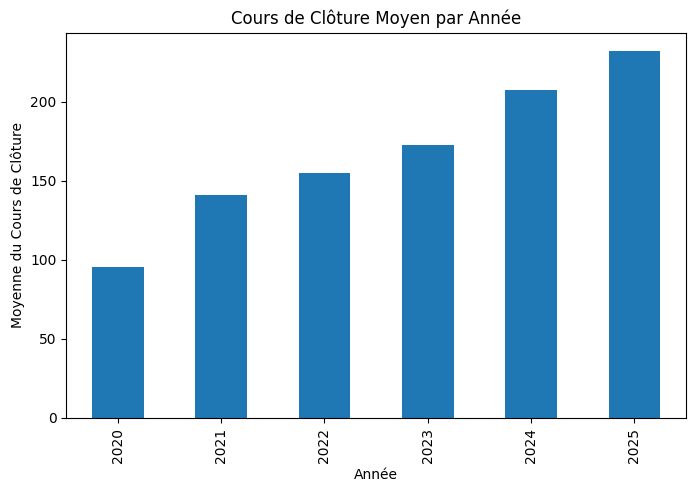

In [79]:
# Ajouter une colonne "Année"
df['Year'] = pd.DatetimeIndex(df['Date']).year

# Calculer la moyenne du cours de clôture par année
yearly_avg = df.groupby('Year')['Close'].mean()
print(yearly_avg)

# Visualisation
yearly_avg.plot(kind='bar', figsize=(8,5))
plt.xlabel("Année")
plt.ylabel("Moyenne du Cours de Clôture")
plt.title("Cours de Clôture Moyen par Année")
plt.show()

8. Normalisation des Données Numériques (Min-Max)

In [80]:
# Colonnes à normaliser
cols_to_normalize = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Application du MinMaxScaler
scaler = MinMaxScaler()
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# Suppression de la colonne MA_20
df = df.drop(columns=['MA_20'])

# Vérification statistique après normalisation
print(df[cols_to_normalize].describe())

# Sauvegarde du fichier normalisé
df.to_csv("data/apple_data_normalized.csv", index=False, encoding='utf-8')
print("Les données normalisées ont été enregistrées dans data/apple_data_normalized.csv")

              Open         High          Low        Close    Adj Close  \
count  1316.000000  1316.000000  1316.000000  1316.000000  1316.000000   
mean      0.498945     0.502626     0.501815     0.499950     0.495590   
std       0.216984     0.216284     0.212264     0.215297     0.216990   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.364990     0.369365     0.370843     0.368218     0.360664   
50%       0.487424     0.493497     0.490439     0.489085     0.485217   
75%       0.624609     0.627691     0.627470     0.624871     0.623085   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Volume  
count  1316.000000  
mean      0.162872  
std       0.130803  
min       0.000000  
25%       0.076639  
50%       0.127939  
75%       0.203897  
max       1.000000  
Les données normalisées ont été enregistrées dans data/apple_data_normalized.csv


## <p style='color: #F88379;'>Partie 4 : Conclusion et Prochaines Étapes</p>

- Résumé : Nous avons extrait, nettoyé et analysé les données historiques d'Apple.
- Perspectives : Utiliser ces données pour entraîner un agent de trading (par exemple, via Q-Learning), effectuer des backtests, et optimiser la stratégie.